In [ ]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms

from IPython.display import clear_output
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

## Training CNN

In [ ]:
class TrainData(Dataset):
    def __init__(self, patients):
        super().__init__()
        self.patients = patients
    
    def __len__(self):
        return len(self.patients)
        
    def __getitem__(self, idx):  
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = f'train_png/{self.patients["patientId"].iloc[idx]}.png'
        image = torchvision.io.read_image(img_name)
        image = image / 255

        records = self.patients.iloc[idx]
        boxes = records[['x', 'y', 'width', 'height']].values.astype(float)
        boxes[2] = boxes[0] + boxes[2]
        boxes[3] = boxes[1] + boxes[3]
        boxes = boxes / 1024

        label = torch.tensor(self.patients['Target'].iloc[idx])
        box = torch.from_numpy(boxes).to(torch.float32)

        return {'image': image, 'label': label, 'box': box}

In [ ]:
data = pd.read_csv('stage_2_train_labels.csv')
data[['x', 'y', 'width', 'height']] = data[['x', 'y', 'width', 'height']].fillna(0)
data['Area'] = data.apply(lambda x: x['width'] * x['height'], axis=1)
data = data.sort_values(by=['Area'])
patients = data.drop_duplicates(subset=['patientId'], keep='last')

In [ ]:
patients_train, patients_test = train_test_split(patients, test_size=0.2, random_state=42, stratify=patients['Target'])

In [ ]:
batch_size = 64
train_dataset = TrainData(patients_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataset = TrainData(patients_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
def plot_progress(train_losses):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=1)
    f.set_figheight(6)
    f.set_figwidth(20)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()

    plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class ObjectDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(pretrained=False)
        self.resnet.fc = nn.Identity()

        self.regressor = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 4), nn.Sigmoid()
        )

        self.classifier = nn.Sequential(
                nn.Dropout(p=0.2),
                nn.Linear(in_features=512, out_features=2)
            )
  
    def forward(self, x):
        features = self.resnet(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)

        return (bboxes, classLogits)
    
    def get_features(self, x):
        x = self.resnet(x)
        x = torch.flatten(x, 1)
        return x

In [ ]:
def plot_progress(train_losses, train_accs, test_losses, test_accs):
    clear_output(True)
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(20)
    
    ax1.plot(train_losses, label='train loss')
    ax1.plot(test_losses, label='val loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()
    
    ax2.plot(train_accs, label='train acc')
    ax2.plot(test_accs, label='val acc')
    ax2.plot(np.ones_like(train_accs), '--', label='100% ROC-AUC')
    ax2.plot(np.ones_like(train_accs) * 0.5, '--', label='50% ROC-AUC')
    ax2.set_ylim(-0.05)
    ax2.set_title('ROC-AUC')
    ax2.set_ylabel('ROC-AUC')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

In [ ]:
model = ObjectDetector()
model = model.to(device)

classLossFunc = nn.CrossEntropyLoss()
bboxLossFunc = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [ ]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []

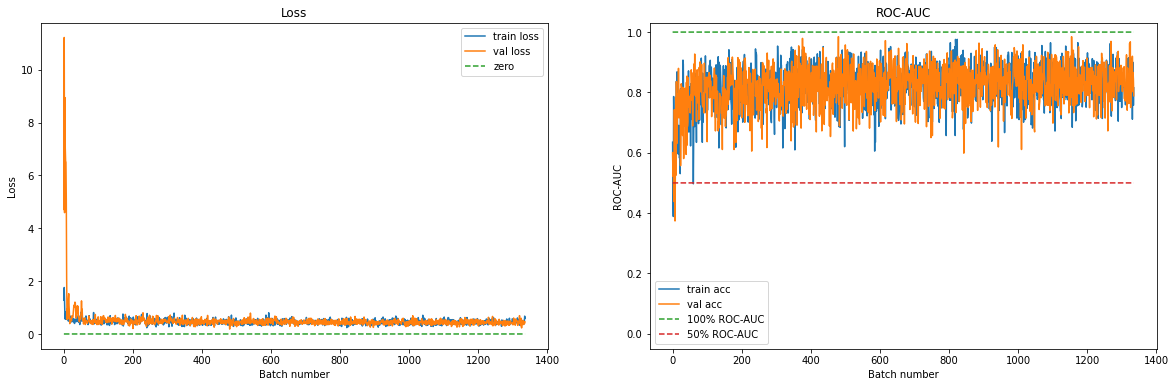

In [ ]:
for epoch in range(4):
    for train_batch in train_dataloader:
        model.train()

        images = train_batch['image'].to(device)
        labels = train_batch['label'].to(device)
        bboxes = train_batch['box'].to(device)

        predictions = model(images)
        bboxLoss = bboxLossFunc(predictions[0], bboxes)
        classLoss = classLossFunc(predictions[1], labels)
        train_loss = bboxLoss + classLoss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        preds_train = torch.nn.functional.softmax(predictions[1], 1)[:, 1]
        trainCorrect = (roc_auc_score(train_batch['label'].numpy(), preds_train.detach().cpu().numpy()))

        model.eval()
        test_batch = next(iter(test_dataloader))
        with torch.no_grad():
            images = test_batch['image'].to(device)
            labels = test_batch['label'].to(device)
            bboxes = test_batch['box'].to(device)

            predictions = model(images)
            bboxLoss = bboxLossFunc(predictions[0], bboxes)
            classLoss = classLossFunc(predictions[1], labels)
            test_loss = bboxLoss + classLoss

            preds_test = torch.nn.functional.softmax(predictions[1], 1)[:, 1]
            valCorrect = (roc_auc_score(test_batch['label'].numpy(), preds_test.detach().cpu().numpy()))

        train_losses.append(train_loss.cpu().detach().numpy())
        train_accs.append(trainCorrect)
        test_losses.append(test_loss.cpu().detach().numpy())
        test_accs.append(valCorrect)

        plot_progress(train_losses, train_accs, test_losses, test_accs)
    scheduler.step()

torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, f'weights/detection_epoch_{epoch}.pt')

In [ ]:
correct_test = []
predicted_test = []
accuracy = 0

model.eval()
for test_batch in test_dataloader:
    with torch.no_grad():
        data_test = test_batch['image'].to(device)
        _, out_test = model(data_test.float())
        preds_test = torch.nn.functional.softmax(out_test, 1)[:, 1]

        correct_test += test_batch['label'].numpy().tolist()
        predicted_test += preds_test.detach().cpu().numpy().tolist()

        _, preds_test = torch.max(out_test, 1)
        accuracy += sum(test_batch['label'].numpy() == preds_test.detach().cpu().numpy())

print(roc_auc_score(correct_test, predicted_test))
print(accuracy / len(test_dataset))

0.8318982670961537
0.8199362937980139


## Image retrieval

In [ ]:
test_shape = len(test_dataset)
test_array = np.zeros((test_shape, 512))
test_y = np.zeros(test_shape)

with torch.no_grad():
    for i, sample in tqdm(enumerate(test_dataloader), total=84):
        l = i * batch_size
        r = min((i + 1) * batch_size, test_shape)

        test_y[l : r] = sample['label']

        out_test = model.get_features(sample['image'].to(device).float())
        out_test = torch.squeeze(out_test).detach().cpu().numpy()
        test_array[l : r, :] = out_test

100%|██████████| 84/84 [00:22<00:00,  3.80it/s]


In [ ]:
train_shape = len(train_dataset)
train_array = np.zeros((train_shape, 512))
train_y = np.zeros(train_shape)

with torch.no_grad():
    for i, sample in tqdm(enumerate(train_dataloader), total=334):
        l = i * batch_size
        r = min((i + 1) * batch_size, train_shape)

        train_y[l : r] = sample['label']

        out_train = model.get_features(sample['image'].to(device).float())
        out_train = torch.squeeze(out_train).detach().cpu().numpy()
        train_array[l : r, :] = out_train

100%|██████████| 334/334 [01:25<00:00,  3.90it/s]


In [ ]:
with open('arrays_detection.npy', 'wb') as f:
    np.save(f, test_array)
    np.save(f, test_y)
    np.save(f, train_array)
    np.save(f, train_y)

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(train_array, train_y)
y_pred = neigh.predict(test_array)
accuracy_score(test_y, y_pred)

0.7948285553681844

## Statistics

In [ ]:
df = pd.read_csv('stage_2_train_labels.csv')

In [ ]:
num_pn = df['patientId'].value_counts()

In [ ]:
sum(df['Target'] == 0)

20672

In [ ]:
num_pn.value_counts()

1    23286
2     3266
3      119
4       13
Name: patientId, dtype: int64